In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt
import numpy as np
import os

# --- Define RHS network architecture ---
class RHS(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key=None):
        dummy_key = jax.random.PRNGKey(0) if key is None else key
        self.mlp = eqx.nn.MLP(in_size=264, out_size=262, width_size=512, depth=4, key=dummy_key)

    def __call__(self, P, H, t):
        x = jnp.concatenate([P, H, jnp.atleast_1d(t)])
        return self.mlp(x)

# --- Load trained model ---
model_path = "/srv/scratch2/taylor.4264/odd_emu/models/learned_model.eqx"
model = RHS()
model_params = eqx.tree_deserialise_leaves(model_path, model)
model = eqx.combine(model_params, model)

# --- Load H(z) and interpolation function ---
Hz_all = np.load("/srv/scratch2/taylor.4264/odd_emu/batched/Hz_all.npy")  # shape (30000, 50)
z_grid = np.load("/srv/scratch2/taylor.4264/odd_emu/batched/z.npy")       # shape (50,)
Hz_ref = Hz_all[0]  # Use first trajectory for H(z) or average over many
def H_func(z):
    return jnp.interp(z, z_grid, Hz_ref)

# --- Define the ODE system ---
def rhs(t, P, args):
    model, H_fn = args
    H_t = jnp.atleast_1d(H_fn(t))  # shape (1,)
    return model(P, H_t, t)        # shape (262,)

# --- Initial condition and time grid ---
P0 = np.load("/srv/scratch2/taylor.4264/odd_emu/batched/pk_nl_all.npy")[0, 0]  # shape (262,)
z0, z1 = float(z_grid[0]), float(z_grid[-1])  # Integration interval

ts = jnp.linspace(z0, z1, 100)  # output time steps
term = ODETerm(rhs)
solver = Tsit5()
saveat = SaveAt(ts=ts)

# --- Integrate using learned dynamics ---
sol = diffeqsolve(
    term,
    solver,
    t0=z0,
    t1=z1,
    dt0=1e-2,
    y0=jnp.array(P0),
    args=(model, H_func),
    saveat=saveat
)

# --- sol.ys contains integrated P(z) of shape (100, 262)
print("Integrated P(z) shape:", sol.ys.shape)

Integrated P(z) shape: (100, 262)


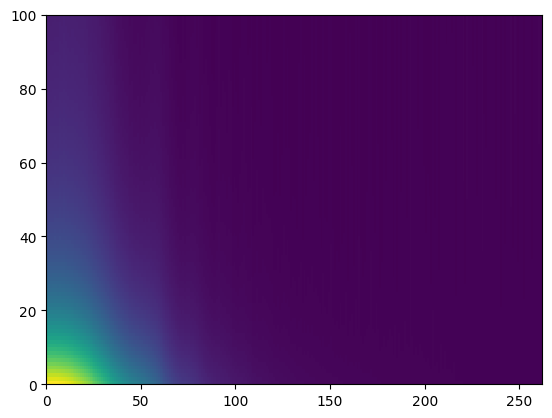

In [4]:
from matplotlib import pyplot as plt
plt.pcolormesh(sol.ys)